In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import seaborn as sns
import os
import datetime
from mpl_toolkits.mplot3d import Axes3D
from termcolor import colored as cl
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

## Read data & preprocess

In [2]:
df = pd.read_csv("carrefour_sales.csv")

In [3]:
df.columns=["id","order_date","product","sales_price","quantity","department","store","city","district","customer","sex","age_group"]
df['total_price'] = df['sales_price']*df['quantity']
df['order_date_notime'] = pd.to_datetime(df['order_date']).dt.floor('d')
df = df[df['quantity']>=0]
df = df[df['age_group'].notna()]

In [4]:
def checkunique(n):
    return df[n].unique()
for i in df.columns:
    num = str(len(checkunique(i)))
    print("%s: %s" %(i, num))

id: 689776
order_date: 398807
product: 27691
sales_price: 1387
quantity: 114
department: 30
store: 101
city: 17
district: 65
customer: 163385
sex: 3
age_group: 13
total_price: 2436
order_date_notime: 612


## Customer RFM
https://medium.com/web-mining-is688-spring-2021/using-k-means-to-segment-customers-based-on-rfm-variables-9d4d683688c8

In [5]:
RFM_df = df.groupby("customer").agg(
    last_date = ('order_date_notime','max'),
    F = ('order_date_notime','count'), #消費次數
    M = ('total_price','sum'), #消費金額
).reset_index()
import datetime
# 以資料最後日期為時間點計算
today= df['order_date_notime'].max()
today
RFM_df['R'] = (pd.to_datetime(today)-RFM_df['last_date']).dt.days #最近消費日期

In [107]:
from sklearn.preprocessing import LabelEncoder
def labelencoding(table, n):
    map_code = pd.DataFrame()
    le = LabelEncoder()
    le.fit(table[n])
    map_code[n]=table[n]
    table[n] = le.transform(table[n])
    map_code['new_code']=table[n]
    return map_code
x = (RFM_df['R'])
y = (RFM_df['F'])
z = (RFM_df['M'])
temp = RFM_df.drop(columns=['last_date'])
code = labelencoding(temp, 'customer')
temp['customer']= code['new_code']

## label to make data in each cluster equal

In [19]:
def cutbin(attr):
    cutlevel = []
    for i in range(0,12,2):
        i = i*0.1
        n = RFM_df[attr].quantile(i)
        if RFM_df[attr].min() == 0 and i<0.1:
            n = -1
        if RFM_df[attr].min() == 1 and i<0.1:
            n = 0
        cutlevel.append(n)
    return cutlevel
#classification equally separate
RFM_df['R_score'] = pd.cut(RFM_df['R'],
                           bins=cutbin('R'),
                           labels=[5,4,3,2,1]
).astype(float)

RFM_df['F_score'] = pd.cut(RFM_df['F'],
                           bins=cutbin('F'),
                           labels=[1,2,3,4,5]
).astype(float)

RFM_df['M_score'] = pd.cut(RFM_df['M'],
                           bins=cutbin('M'),
                           labels=[1,2,3,4,5]
).astype(float)

In [79]:
RFM_score = pd.DataFrame(RFM_df, columns= ['R_score','F_score','M_score'])
RFM_score = RFM_score.copy(deep=True)

In [80]:
RFM_score

,R_score,F_score,M_score
0,4.0,2.0,1.0
1,2.0,1.0,3.0
2,1.0,1.0,1.0
3,5.0,5.0,5.0
4,4.0,5.0,4.0
...,...,...,...
163380,5.0,5.0,5.0
163381,1.0,3.0,3.0
163382,1.0,5.0,3.0
163383,3.0,4.0,3.0


In [119]:
from sklearn.cluster import KMeans
%matplotlib inline
import matplotlib.pyplot as plt 
def classification_(n):
    wcss = []
    # 計算 k=1~10 的損失函數
    for i in range(1,11):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
        kmeans.fit(temp)
        # kmeans.inertia_
        wcss.append(kmeans.inertia_)
    plt.plot(range(1,11), wcss, marker='o')
    plt.title('Elbow graph')
    plt.xlabel('Cluster number')
    plt.ylabel('WCSS')
    plt.show()

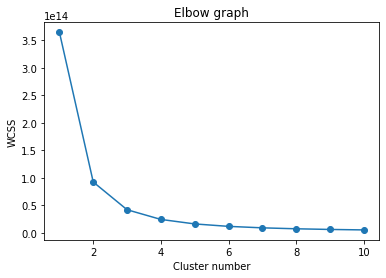

In [120]:
classification_(temp)

## RFM 
- 最大者 VIP

In [133]:
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=0)
RFM_score['clusters'] = kmeans.fit_predict(RFM_score)
print(round(pd.DataFrame(kmeans.cluster_centers_),2))

      0     1     2     3
0  3.22  1.87  1.80  0.97
1  2.64  1.97  3.81  5.47
2  1.38  1.39  1.31  7.00
3  1.99  4.28  4.02  1.09
4  4.45  4.44  4.10  3.63


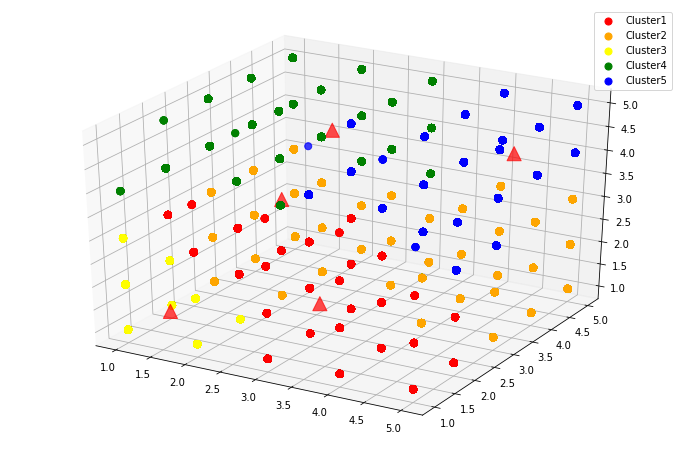

In [134]:
from mpl_toolkits.mplot3d import Axes3D 
colors=['red', 'orange', 'yellow', 'green','blue']
fig = plt.figure()
fig.set_size_inches(12, 8)
ax = fig.add_subplot(111, projection='3d')
for i in range(kmeans.n_clusters):
    df=RFM_score[RFM_score['clusters']==i]
    ax.scatter(df['R_score'], df['M_score'],df['F_score'],s=50,label='Cluster'+str(i+1), c=colors[i])
plt.legend()

ax.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],kmeans.cluster_centers_[:,2],s=200,marker='^', c='red', alpha=0.7, label='Centroids')

In [135]:
#classification result
for i in range(kmeans.n_clusters):
    df=RFM_score[RFM_score['clusters']==i]
    print(df)

        R_score  F_score  M_score  clusters
0           4.0      2.0      1.0         0
16          4.0      2.0      2.0         0
24          3.0      2.0      2.0         0
25          5.0      2.0      1.0         0
26          4.0      2.0      1.0         0
...         ...      ...      ...       ...
163369      4.0      2.0      2.0         0
163370      4.0      2.0      2.0         0
163375      4.0      2.0      1.0         0
163378      3.0      2.0      3.0         0
163379      5.0      2.0      2.0         0

[43492 rows x 4 columns]
        R_score  F_score  M_score  clusters
1           2.0      1.0      3.0         1
7           5.0      2.0      3.0         1
14          4.0      3.0      4.0         1
15          4.0      2.0      3.0         1
17          4.0      2.0      3.0         1
...         ...      ...      ...       ...
163345      1.0      3.0      3.0         1
163361      2.0      2.0      5.0         1
163363      3.0      2.0      4.0         1
163376

==========================================================
### 1. R、F、M each cluster 2. label 3. kmeans

In [94]:
temp

,customer,F,M,R,R_score,F_score,M_score
0,0,3,195,159,4.0,2.0,1.0
1,1,1,579,265,2.0,1.0,3.0
2,2,1,164,596,1.0,1.0,1.0
3,3,22,3220,50,5.0,5.0,5.0
4,4,10,972,96,4.0,5.0,4.0
...,...,...,...,...,...,...,...
163380,163380,13,1724,47,5.0,5.0,5.0
163381,163381,4,715,440,1.0,3.0,3.0
163382,163382,12,675,453,1.0,5.0,3.0
163383,163383,5,611,214,3.0,4.0,3.0


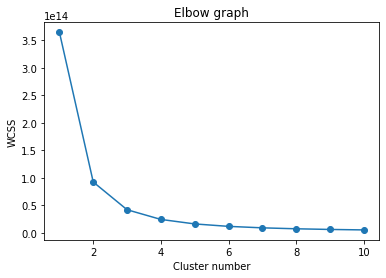

In [121]:
classification_(temp[['R']])

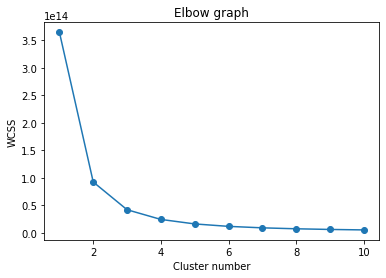

In [122]:
classification_(temp[['F']])

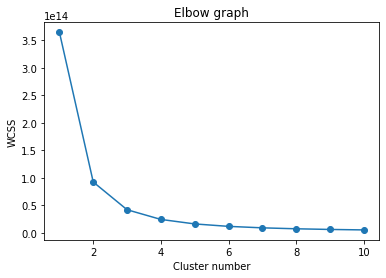

In [123]:
classification_(temp[['M']])

### result: RFM都分 5 群

In [124]:
# R_cluster
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=0)
temp['R_cluster'] = kmeans.fit_predict(temp[['R']])

In [125]:
#F_cluster
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=0)
temp['F_cluster'] = kmeans.fit_predict(temp[['F']])

In [126]:
#M_cluster
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=0)
temp['M_cluster'] = kmeans.fit_predict(temp[['M']])

In [127]:
RFM_cluster = pd.DataFrame(temp, columns= ['R_cluster','F_cluster','M_cluster'])
RFM_cluster = RFM_cluster.copy(deep=True)

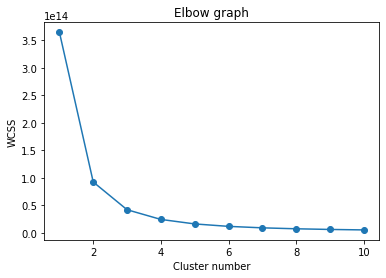

In [128]:
classification_(RFM_cluster)#分四群

In [130]:
RFM_cluster

,R_cluster,F_cluster,M_cluster,clusters
0,0,0,0,1
1,2,0,0,0
2,1,0,0,1
3,4,1,4,3
4,0,3,0,2
...,...,...,...,...
163380,4,3,0,2
163381,1,0,0,1
163382,1,3,0,2
163383,2,0,0,0


In [129]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0)
RFM_cluster['clusters'] = kmeans.fit_predict(RFM_cluster)

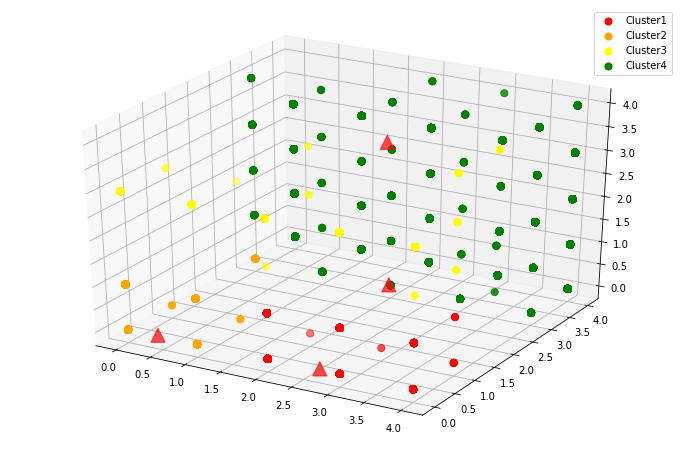

In [131]:
colors=['red', 'orange', 'yellow', 'green']
fig = plt.figure()
fig.set_size_inches(12, 8)
ax = fig.add_subplot(111, projection='3d')
for i in range(kmeans.n_clusters):
    df=RFM_cluster[RFM_cluster['clusters']==i]
    ax.scatter(df['R_cluster'], df['M_cluster'],df['F_cluster'],s=50,label='Cluster'+str(i+1), c=colors[i])
plt.legend()

ax.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],kmeans.cluster_centers_[:,2],s=200,marker='^', c='red', alpha=0.7, label='Centroids')

In [132]:
#classification result
for i in range(kmeans.n_clusters):
    df=RFM_cluster[RFM_cluster['clusters']==i]
    print(df)

        R_cluster  F_cluster  M_cluster  clusters
1               2          0          0         0
5               3          0          0         0
6               3          0          0         0
7               4          0          0         0
8               4          0          0         0
...           ...        ...        ...       ...
163363          2          0          0         0
163365          2          0          0         0
163366          2          0          0         0
163379          4          0          0         0
163383          2          0          0         0

[66891 rows x 4 columns]
        R_cluster  F_cluster  M_cluster  clusters
0               0          0          0         1
2               1          0          0         1
14              0          0          0         1
15              0          0          0         1
16              0          0          0         1
...           ...        ...        ...       ...
163374          0       